In [6]:
# Install required packages if not present
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

required_packages = ['pandas', 'yfinance', 'xlsxwriter', 'openpyxl', 'seaborn', 'matplotlib']
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)

In [7]:
import pandas as pd
import yfinance as yf
from datetime import datetime

# List of ETF symbols
etf_symbols = [
    # List all symbols in the exact order as provided
    'MOM30IETF', 'NIFTYQLITY', 'VAL30IETF', 'ABSLPSE', 'UTISXN50',
    'CPSEETF', 'GOLDBEES', 'HNGSNGBEES', 'MAHKTECH', 'HDFCGROWTH',
    'LOWVOLIETF', 'HDFCQUAL', 'BSE500IETF', 'COMMOIETF', 'FINIETF',
    'INFRAIETF', 'MNC', 'ALPHAETF', 'MIDSMALL', 'SMALLCAP',
    'MONIFTY500', 'MOREALTY', 'MOSMALL250', 'MOVALUE', 'MONQ50',
    'MON100', 'TOP100CASE', 'NIFTYBEES', 'MOMENTUM50', 'ALPHA',
    'ALPL30IETF', 'AUTOIETF', 'BANKBEES', 'DIVOPPBEES', 'EVINDIA',
    'BFSI', 'FMCGIETF', 'HEALTHY', 'MOHEALTH', 'CONSUMBEES',
    'MODEFENCE', 'TNIDETF', 'MAKEINDIA', 'ITBEES', 'METALIETF',
    'MOM100', 'MIDCAPETF', 'MIDQ50ADD', 'MIDCAP', 'NEXT50IETF',
    'OILIETF', 'PHARMABEES', 'PVTBANIETF', 'PSUBNKBEES', 'TOP10ADD',
    'ESG', 'NV20IETF', 'MULTICAP', 'EMULTIMQ', 'MAFANG',
    'MASPTOP50', 'ICICIB22', 'MIDSELIETF', 'SILVERBEES', 'SENSEXIETF',
    'SHARIABEES'
]

# Dictionary to store ETF data and summary
etf_historical_data = {}
summary_data = []

# Fetch data for each ETF
for symbol in etf_symbols:
    try:
        # Get ETF data
        etf = yf.Ticker(f"{symbol}.NS")
        hist_data = etf.history(period="max")
        
        if not hist_data.empty:
            # Convert timezone-aware data to timezone-naive
            hist_data.index = hist_data.index.tz_localize(None)
            etf_historical_data[symbol] = hist_data
            
            # Calculate metrics for summary
            cmp = hist_data['Close'].iloc[-1]
            low_52w = hist_data['Low'].tail(252).min()
            high_52w = hist_data['High'].tail(252).max()
            low_diff = cmp - low_52w
            low_change_pct = (low_diff / low_52w) * 100
            
            summary_data.append({
                'Symbol': symbol,
                'CMP': cmp,
                '52W Low': low_52w,
                '52W High': high_52w,
                'CMP - 52W Low': low_diff,
                '% Change from 52W Low': low_change_pct
            })
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

# Write to Excel with better error handling
try:
    with pd.ExcelWriter('indian_etf_analysis.xlsx', engine='openpyxl') as writer:
        summary_df.to_excel(writer, sheet_name='Summary', index=False)
        for symbol, data in etf_historical_data.items():
            sheet_name = symbol[:31]  # Excel sheet names limited to 31 chars
            data.to_excel(writer, sheet_name=sheet_name)
except Exception as e:
    print(f"Error writing Excel file: {e}")
    # Save as CSV files if Excel writing fails
    summary_df.to_csv('etf_summary.csv', index=False)
    for symbol, data in etf_historical_data.items():
        data.to_csv(f'etf_data_{symbol}.csv')

print("Data has been written successfully")

Data has been written successfully


In [8]:
# Create Rankings sheet with detailed metrics for top 3 ETFs
import pandas as pd
from datetime import datetime

# Create date range from 2018 to present
date_range = pd.date_range(start='2018-01-01', end=pd.Timestamp.today(), freq='B')

# Initialize rankings DataFrame with detailed columns for each rank
rankings_columns = [
    'Date',
    # Rank 1 ETF details
    'Rank1_Symbol', 'Rank1_CMP', 'Rank1_52W_Low', 'Rank1_52W_High',
    'Rank1_Above_Low', 'Rank1_%_From_Low', 'Rank1_Investment', 'Rank1_Units',
    # Rank 2 ETF details
    'Rank2_Symbol', 'Rank2_CMP', 'Rank2_52W_Low', 'Rank2_52W_High',
    'Rank2_Above_Low', 'Rank2_%_From_Low', 'Rank2_Investment', 'Rank2_Units',
    # Rank 3 ETF details
    'Rank3_Symbol', 'Rank3_CMP', 'Rank3_52W_Low', 'Rank3_52W_High',
    'Rank3_Above_Low', 'Rank3_%_From_Low', 'Rank3_Investment', 'Rank3_Units'
]

rankings_df = pd.DataFrame(columns=rankings_columns, index=date_range)
rankings_df['Date'] = date_range
daily_investment = 5000

# Calculate rankings for each date
for date in date_range:
    daily_rankings = []
    
    # Calculate metrics for each ETF
    for symbol, data in etf_historical_data.items():
        try:
            data_until_date = data[:date]
            if not data_until_date.empty:
                cmp = data_until_date['Close'].iloc[-1]
                low_52w = data_until_date['Low'].tail(252).min()
                high_52w = data_until_date['High'].tail(252).max()
                low_diff = cmp - low_52w
                low_change_pct = (low_diff / low_52w) * 100
                
                daily_rankings.append({
                    'Symbol': symbol,
                    'CMP': cmp,
                    '52W_Low': low_52w,
                    '52W_High': high_52w,
                    'Above_Low': low_diff,
                    '%_From_Low': low_change_pct
                })
        except Exception:
            continue
    
    # Sort by % from 52-week low (ascending) and get top 3
    daily_rankings.sort(key=lambda x: x['%_From_Low'])
    top_3 = daily_rankings[:3]
    
    # Fill rankings data for each rank
    for rank, etf in enumerate(top_3, 1):
        rank_prefix = f'Rank{rank}_'
        rankings_df.at[date, f'{rank_prefix}Symbol'] = etf['Symbol']
        rankings_df.at[date, f'{rank_prefix}CMP'] = etf['CMP']
        rankings_df.at[date, f'{rank_prefix}52W_Low'] = etf['52W_Low']
        rankings_df.at[date, f'{rank_prefix}52W_High'] = etf['52W_High']
        rankings_df.at[date, f'{rank_prefix}Above_Low'] = etf['Above_Low']
        rankings_df.at[date, f'{rank_prefix}%_From_Low'] = etf['%_From_Low']
        
        # Calculate investment and units for each rank
        rank_investment = daily_investment if rank == 1 else 0
        rankings_df.at[date, f'{rank_prefix}Investment'] = rank_investment
        rankings_df.at[date, f'{rank_prefix}Units'] = rank_investment / etf['CMP'] if rank == 1 else 0

# Write updated Excel file with new Rankings sheet
try:
    with pd.ExcelWriter('indian_etf_analysis.xlsx', engine='openpyxl', mode='a') as writer:
        rankings_df.to_excel(writer, sheet_name='Rankings', index=False)
        
        # Get the workbook and worksheet
        workbook = writer.book
        worksheet = writer.sheets['Rankings']
        
        # Add summary formulas
        last_row = len(rankings_df) + 2
        formulas = [
            ('Total Rank1 Investment', f'=SUM(H2:H{len(rankings_df)+1})'),
            ('Total Rank1 Units', f'=SUM(I2:I{len(rankings_df)+1})'),
            ('Average %_From_Low Rank1', f'=AVERAGE(G2:G{len(rankings_df)+1})')
        ]
        
        for idx, (label, formula) in enumerate(formulas):
            worksheet.cell(row=last_row+idx, column=1, value=label)
            worksheet.cell(row=last_row+idx, column=2, value=formula)
            
except Exception as e:
    print(f"Error adding Rankings sheet: {e}")
    rankings_df.to_csv('rankings.csv', index=False)

print("Updated Rankings data has been added successfully")

Updated Rankings data has been added successfully


In [9]:
# Create Returns sheet with cumulative investment tracking
import pandas as pd
import numpy as np

# Initialize returns DataFrame
returns_columns = [
    'Date', 'Cumulative_Investment',
    'Rank1_Value', 'Rank2_Value', 'Rank3_Value'
]

returns_df = pd.DataFrame(columns=returns_columns, index=date_range)
returns_df['Date'] = date_range

# Dictionary to store accumulated units for each symbol
symbol_units = {}

# Process each date
for current_date in date_range:
    # Get investment data up to current date
    investments_till_date = rankings_df[rankings_df['Date'] <= current_date]
    
    # Calculate cumulative investment
    cumulative_investment = len(investments_till_date) * daily_investment
    returns_df.at[current_date, 'Cumulative_Investment'] = cumulative_investment
    
    # Process each rank
    for rank in range(1, 4):  # Process ranks 1-3
        rank_value = 0
        
        # Get unique symbols for this rank up to current date
        rank_symbols = investments_till_date[f'Rank{rank}_Symbol'].unique()
        
        for symbol in rank_symbols:
            if pd.notna(symbol):  # Check if symbol is not NaN
                # Get all investments in this symbol for this rank
                symbol_investments = investments_till_date[
                    investments_till_date[f'Rank{rank}_Symbol'] == symbol
                ]
                
                # Sum up units bought for this symbol
                total_units = symbol_investments[f'Rank{rank}_Units'].sum()
                
                # Get current price for this symbol
                try:
                    current_price = etf_historical_data[symbol].loc[current_date, 'Close']
                    # Add to rank value
                    rank_value += total_units * current_price
                except KeyError:
                    # Use the last available price if current date's price is not available
                    mask = etf_historical_data[symbol].index <= current_date
                    if mask.any():
                        last_price = etf_historical_data[symbol].loc[mask, 'Close'][-1]
                        rank_value += total_units * last_price
        
        # Store the total value for this rank
        returns_df.at[current_date, f'Rank{rank}_Value'] = rank_value

# Calculate additional metrics
for rank in range(1, 4):
    returns_df[f'Rank{rank}_Returns%'] = (
        (returns_df[f'Rank{rank}_Value'] - returns_df['Cumulative_Investment']) 
        / returns_df['Cumulative_Investment'] * 100
    )

# Write Returns sheet to Excel
try:
    with pd.ExcelWriter('indian_etf_analysis.xlsx', engine='openpyxl', mode='a') as writer:
        returns_df.to_excel(writer, sheet_name='Returns', index=False)
        
        # Get the workbook and worksheet
        workbook = writer.book
        worksheet = writer.sheets['Returns']
        
        # Add summary formulas
        last_row = len(returns_df) + 2
        summary_formulas = [
            ('Total Investment', f'=B{len(returns_df)+1}'),
            ('Final Rank1 Value', f'=C{len(returns_df)+1}'),
            ('Final Rank1 Returns%', f'=(C{len(returns_df)+1}-B{len(returns_df)+1})/B{len(returns_df)+1}*100'),
            ('Max Rank1 Returns%', f'=MAX(F2:F{len(returns_df)+1})'),
            ('Min Rank1 Returns%', f'=MIN(F2:F{len(returns_df)+1})')
        ]
        
        for idx, (label, formula) in enumerate(summary_formulas):
            worksheet.cell(row=last_row+idx, column=1, value=label)
            worksheet.cell(row=last_row+idx, column=2, value=formula)

except Exception as e:
    print(f"Error adding Returns sheet: {e}")
    returns_df.to_csv('returns.csv', index=False)

print("Returns data has been added successfully")

/tmp/ipykernel_1418/3991270359.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_price = etf_historical_data[symbol].loc[mask, 'Close'][-1]


Returns data has been added successfully


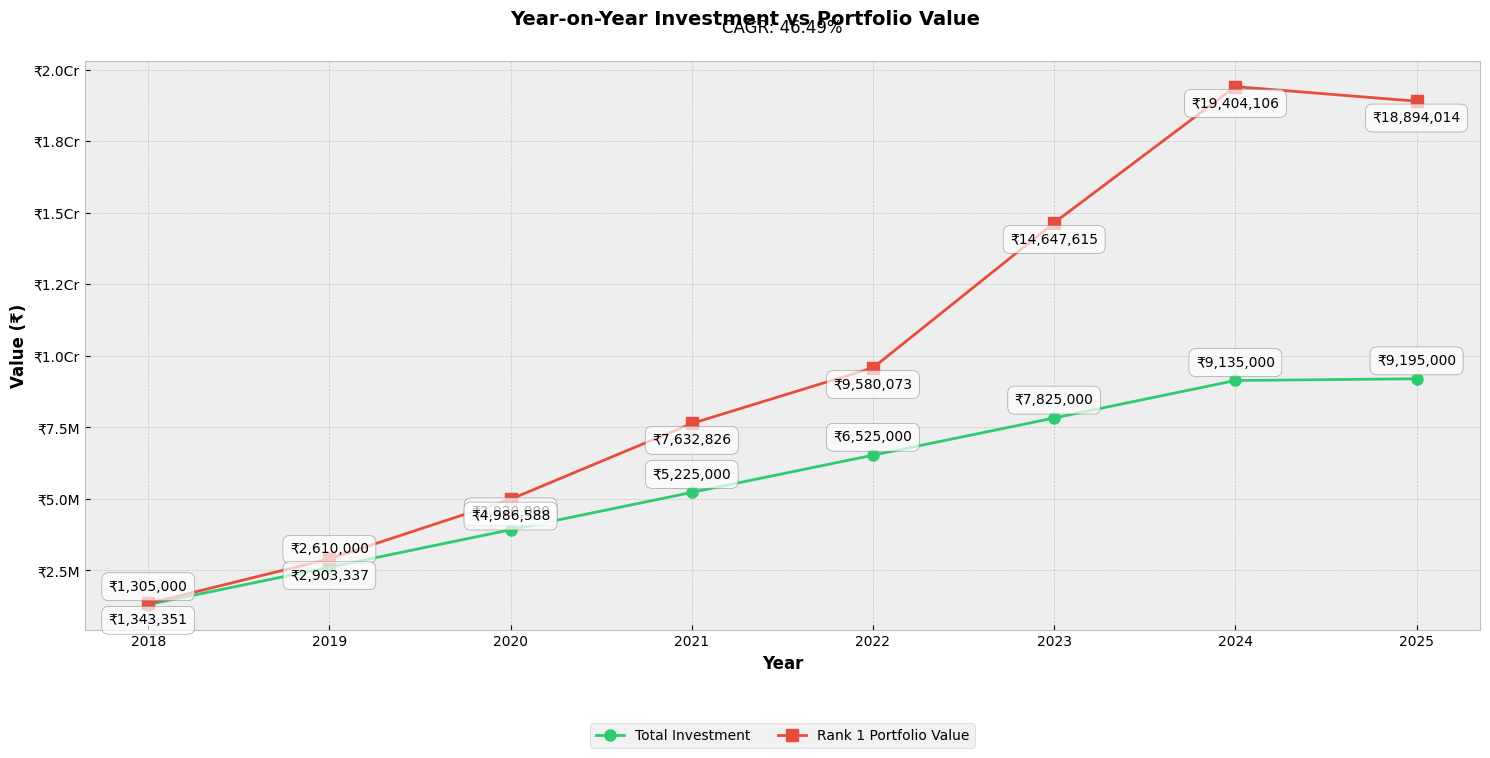

In [10]:
# Create year-on-year trend chart
import matplotlib.pyplot as plt

# Use a built-in style
plt.style.use('bmh')

# Create figure with high DPI
plt.figure(figsize=(15, 8), dpi=100)

# Add year to returns_df and prepare yearly data
returns_df['Year'] = returns_df['Date'].dt.year
yearly_data = returns_df.groupby('Year').last().reset_index()

# Create the line plot with custom colors
plt.plot(yearly_data['Year'], yearly_data['Cumulative_Investment'],
         marker='o', linewidth=2, label='Total Investment',
         color='#2ecc71', markersize=8)
plt.plot(yearly_data['Year'], yearly_data['Rank1_Value'],
         marker='s', linewidth=2, label='Rank 1 Portfolio Value',
         color='#e74c3c', markersize=8)

# Function to add value labels with background
def add_value_label(x, y, label, offset_y=10):
    plt.annotate(label, (x, y),
                 textcoords="offset points",
                 xytext=(0, offset_y), 
                 ha='center',
                 bbox=dict(boxstyle='round,pad=0.5',
                          fc='white', ec='gray', alpha=0.7))

# Add value labels for investment and returns
for year, inv, val in zip(yearly_data['Year'],
                         yearly_data['Cumulative_Investment'],
                         yearly_data['Rank1_Value']):
    add_value_label(year, inv, f'₹{inv:,.0f}', 10)
    add_value_label(year, val, f'₹{val:,.0f}', -15)

# Calculate and add CAGR
years = (yearly_data['Year'].max() - yearly_data['Year'].min())
if years > 0:
    initial_investment = yearly_data.iloc[0]['Cumulative_Investment']
    final_value = yearly_data.iloc[-1]['Rank1_Value']
    cagr = ((final_value/initial_investment) ** (1/years) - 1) * 100
    plt.suptitle('Year-on-Year Investment vs Portfolio Value',
                 y=0.95, fontsize=14, fontweight='bold')
    plt.title(f'CAGR: {cagr:.2f}%',
              pad=20, fontsize=12)
else:
    plt.title('Year-on-Year Investment vs Portfolio Value',
              pad=20, fontsize=14, fontweight='bold')

# Enhance plot aesthetics
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Value (₹)', fontsize=12, fontweight='bold')

# Enhanced legend
plt.legend(bbox_to_anchor=(0.5, -0.15),
          loc='upper center',
          ncol=2,
          fontsize=10,
          frameon=True)

# Format y-axis values
def format_value(x, p):
    if x >= 1e7:  # 10 million (1 crore)
        return f'₹{x/1e7:.1f}Cr'
    elif x >= 1e6:  # 1 million
        return f'₹{x/1e6:.1f}M'
    elif x >= 1e3:  # 1 thousand
        return f'₹{x/1e3:.1f}K'
    return f'₹{x:.0f}'

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_value))

# Adjust layout and save outputs
plt.tight_layout()

try:
    # Save high-resolution PNG
    plt.savefig('yearly_trend.png', bbox_inches='tight', dpi=300)
    
    # Add to Excel workbook
    with pd.ExcelWriter('indian_etf_analysis.xlsx',
                        engine='openpyxl', mode='a') as writer:
        yearly_data.to_excel(writer, sheet_name='Yearly_Summary', index=False)
        
        if years > 0:
            worksheet = writer.sheets['Yearly_Summary']
            row = len(yearly_data) + 2
            worksheet.cell(row=row, column=1, value='CAGR')
            worksheet.cell(row=row, column=2, value=f'{cagr:.2f}%')
            
except Exception as e:
    print(f"Error saving outputs: {e}")

plt.show()